# Feature Engineering - CS:GO Dataset

**Objetivo:** Crear nuevas variables relevantes para mejorar las predicciones de regresión y clasificación

**Estrategia:** Aplicar conocimiento del dominio CS:GO para generar features significativas

---

## 1. Importación de Librerías y Configuración

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 2. Carga de Datos

In [33]:
# Intentar cargar datos limpios, si no existen usar datos raw
try:
    df = pd.read_csv(r"C:\Users\LuisSalamanca\Desktop\Duoc\Machine\csgo-ml\data\02_intermediate\csgo_data_clean.csv")
    print(f"Datos limpios cargados: {df.shape}")
except FileNotFoundError:
    print("Archivo de datos limpios no encontrado. Cargando datos raw...")
    df_raw = pd.read_csv("../data/01_raw/Anexo_ET_demo_round_traces_2022.csv", sep=';')
    
    # Limpieza básica
    df = df_raw.copy()
    cols_to_drop = ['TimeAlive', 'TravelledDistance', 'FirstKillTime', 'AbnormalMatch']
    cols_dropped = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(columns=cols_dropped)
    
    # Limpiar variables problemáticas
    df['RoundWinner'] = df['RoundWinner'].replace('False4', 'False')
    df['RoundWinner'] = df['RoundWinner'].map({'True': True, 'False': False})
    df = df.dropna(subset=['MatchWinner'])
    df['MatchWinner'] = df['MatchWinner'].map({'True': True, 'False': False})
    
    print(f"Datos procesados: {df.shape}")

# Información básica del dataset
print(f"\nInformación del dataset:")
print(f"- Filas: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")
print(f"- Mapas: {df['Map'].unique()}")

# Mostrar columnas actuales
print(f"\nColumnas actuales: {list(df.columns)}")

Datos limpios cargados: (79154, 32)

Información del dataset:
- Filas: 79,154
- Columnas: 32
- Mapas: ['de_inferno' 'de_nuke' 'de_mirage' 'de_dust2']

Columnas actuales: ['Map', 'Team', 'InternalTeamId', 'RoundId', 'RoundWinner', 'MatchWinner', 'Survived', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills', 'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots', 'Team_encoded', 'RoundWinner_encoded', 'MatchWinner_encoded', 'Survived_encoded', 'Map_de_dust2', 'Map_de_inferno', 'Map_de_mirage', 'Map_de_nuke']


## 3. Features de Rendimiento (Performance Features)

In [34]:
print("[PERFORMANCE] Creando Features de Rendimiento...")

original_cols = len(df.columns)

# 1. Ratios de Eficiencia
df['Kill_Equipment_Efficiency'] = df['RoundKills'] / (df['RoundStartingEquipmentValue'] + 1)
df['Assist_Equipment_Efficiency'] = df['RoundAssists'] / (df['RoundStartingEquipmentValue'] + 1)

# 2. Ratios de Rendimiento
df['Headshot_Kill_Ratio'] = df['RoundHeadshots'] / (df['RoundKills'] + 1)
df['Assist_Kill_Ratio'] = df['RoundAssists'] / (df['RoundKills'] + 1)
df['Flank_Kill_Ratio'] = df['RoundFlankKills'] / (df['RoundKills'] + 1)

# 3. Rendimiento a Nivel de Partida
df['Match_Kill_Per_Round'] = df['MatchKills'] / df['RoundId']
df['Match_Assist_Per_Round'] = df['MatchAssists'] / df['RoundId']
df['Match_Headshot_Percentage'] = df['MatchHeadshots'] / (df['MatchKills'] + 1)

# 4. Acciones de Combate Totales
df['Total_Combat_Actions'] = df['RoundKills'] + df['RoundAssists'] + df['RoundHeadshots']
df['Total_Match_Actions'] = df['MatchKills'] + df['MatchAssists'] + df['MatchHeadshots']

# 5. Categorías de Rendimiento (Binning)
df['Kill_Performance_Level'] = pd.cut(df['RoundKills'], 
                                     bins=[-1, 0, 1, 2, 5], 
                                     labels=['No_Kills', 'Single_Kill', 'Double_Kill', 'Multi_Kill'])

df['Equipment_Investment_Level'] = pd.cut(df['RoundStartingEquipmentValue'],
                                         bins=[0, 800, 2500, 4500, 10000],
                                         labels=['Eco', 'Force_Buy', 'Semi_Buy', 'Full_Buy'])
df['EffectivenessScore'] = df['RoundKills'] * 2 + df['RoundAssists']
df['EffectivenessLevel'] = pd.cut(
    df['EffectivenessScore'].astype(float),
    bins=[-0.1, 0.5, 2, np.inf],
    labels=['Bajo', 'Medio', 'Alto']
)

performance_features = len(df.columns) - original_cols
print(f"Features de rendimiento creadas: {performance_features}")

[PERFORMANCE] Creando Features de Rendimiento...
Features de rendimiento creadas: 14


## 4. Features Tácticas (Tactical Features)

In [35]:
print("[TACTICAL] Creando Features Tácticas...")

original_cols = len(df.columns)

# 1. Especialización en Armas
weapon_cols = [col for col in df.columns if col.startswith('Primary')]
if weapon_cols:
    # Convertir a numérico si son strings
    for col in weapon_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Arma dominante
    df['Dominant_Weapon'] = df[weapon_cols].idxmax(axis=1)
    df['Weapon_Specialization_Score'] = df[weapon_cols].max(axis=1)
    
    # Diversidad de armas
    df['Weapon_Diversity'] = (df[weapon_cols] > 0).sum(axis=1)
    
    # Preferencias específicas de armas
    df['Prefers_Rifles'] = (df['PrimaryAssaultRifle'] > 0.5).astype(int)
    df['Prefers_AWP'] = (df['PrimarySniperRifle'] > 0.5).astype(int)
    df['Prefers_SMG'] = (df['PrimarySMG'] > 0.5).astype(int)

# 2. Patrones de Uso de Granadas
df['Total_Grenades_Used'] = df['RLethalGrenadesThrown'] + df['RNonLethalGrenadesThrown']
df['Grenade_Lethality_Ratio'] = df['RLethalGrenadesThrown'] / (df['Total_Grenades_Used'] + 1)
df['Utility_Usage_Ratio'] = df['RNonLethalGrenadesThrown'] / (df['Total_Grenades_Used'] + 1)

# 3. Categorías de Uso de Granadas
df['Grenade_Usage_Style'] = 'Conservative'
df.loc[df['Total_Grenades_Used'] >= 3, 'Grenade_Usage_Style'] = 'Aggressive'
df.loc[(df['Total_Grenades_Used'] >= 1) & (df['Total_Grenades_Used'] < 3), 'Grenade_Usage_Style'] = 'Moderate'

# 4. Efectividad Táctica
df['Grenades_Per_Kill'] = df['Total_Grenades_Used'] / (df['RoundKills'] + 1)
df['Equipment_To_Grenade_Ratio'] = df['RoundStartingEquipmentValue'] / (df['Total_Grenades_Used'] * 300 + 1)

tactical_features = len(df.columns) - original_cols
print(f"Features tácticas creadas: {tactical_features}")

[TACTICAL] Creando Features Tácticas...
Features tácticas creadas: 12


## 5. Features Temporales (Temporal Features)

In [36]:
print("[TEMPORAL] Creando Features Temporales...")

original_cols = len(df.columns)

# 1. Fases de Ronda
df['Round_Phase'] = 'Mid'
df.loc[df['RoundId'] <= 6, 'Round_Phase'] = 'Early'
df.loc[df['RoundId'] >= 25, 'Round_Phase'] = 'Late'
df.loc[df['RoundId'] >= 31, 'Round_Phase'] = 'Overtime'

# 2. Rondas Económicas (patrones comunes de CS:GO)
df['Is_Pistol_Round'] = ((df['RoundId'] == 1) | (df['RoundId'] == 16)).astype(int)
df['Is_Anti_Eco_Round'] = ((df['RoundId'] == 2) | (df['RoundId'] == 17)).astype(int)
df['Is_Buy_Round'] = (df['RoundStartingEquipmentValue'] > 3000).astype(int)

# 3. Progreso de Partida
df['Match_Progress_Percentage'] = (df['RoundId'] / 30) * 100
df['Rounds_Remaining'] = np.maximum(0, 30 - df['RoundId'])

# 4. Indicadores de Rondas Críticas
df['Is_Match_Point'] = (df['RoundId'] >= 30).astype(int)
df['Is_Critical_Round'] = ((df['RoundId'] % 5 == 0) & (df['RoundId'] > 10)).astype(int)

# 5. Clasificación de Tipo de Ronda
df['Round_Type'] = 'Regular'
df.loc[df['Is_Pistol_Round'] == 1, 'Round_Type'] = 'Pistol'
df.loc[df['Is_Anti_Eco_Round'] == 1, 'Round_Type'] = 'Anti_Eco'
df.loc[df['RoundStartingEquipmentValue'] < 1000, 'Round_Type'] = 'Eco'
df.loc[df['Is_Match_Point'] == 1, 'Round_Type'] = 'Match_Point'

# 6. Momentum Temporal
df['Early_Round_Performance'] = (df['RoundId'] <= 6).astype(int) * df['RoundKills']
df['Late_Round_Performance'] = (df['RoundId'] >= 25).astype(int) * df['RoundKills']

temporal_features = len(df.columns) - original_cols
print(f"Features temporales creadas: {temporal_features}")

[TEMPORAL] Creando Features Temporales...
Features temporales creadas: 11


## 6. Features de Equipo y Económicas

In [37]:
print("[ECONOMIC] Creando Features de Equipo y Económicas...")

original_cols = len(df.columns)

# 1. Features Económicas
df['Individual_Equipment_Share'] = df['RoundStartingEquipmentValue'] / (df['TeamStartingEquipmentValue'] + 1)
df['Team_Economic_Strength'] = pd.cut(df['TeamStartingEquipmentValue'],
                                     bins=[0, 5000, 15000, 25000, 40000],
                                     labels=['Very_Poor', 'Poor', 'Average', 'Rich'])

# 2. Distribución de Equipamiento
df['Above_Team_Average_Equipment'] = (df['RoundStartingEquipmentValue'] > 
                                     df['TeamStartingEquipmentValue'] / 5).astype(int)

df['Equipment_Advantage_Ratio'] = df['RoundStartingEquipmentValue'] / (df['TeamStartingEquipmentValue'] / 5 + 1)

# 3. Indicadores de Rol de Equipo
df['Likely_Entry_Fragger'] = ((df['Individual_Equipment_Share'] > 0.25) & 
                              (df['RoundKills'] > 0)).astype(int)

df['Likely_Support_Player'] = ((df['RNonLethalGrenadesThrown'] >= 2) & 
                              (df['RoundAssists'] > df['RoundKills'])).astype(int)

# 4. Eficiencia Económica
df['Equipment_ROI'] = (df['RoundKills'] * 300 + df['RoundAssists'] * 150) / (df['RoundStartingEquipmentValue'] + 1)


economic_features = len(df.columns) - original_cols
print(f"Features económicas creadas: {economic_features}")

[ECONOMIC] Creando Features de Equipo y Económicas...
Features económicas creadas: 7


## 7. Features de Interacción

In [38]:
print("[INTERACTION] Creando Features de Interacción...")

original_cols = len(df.columns)

# 1. Interacciones Equipamiento × Rendimiento
df['Equipment_Kills_Interaction'] = df['RoundStartingEquipmentValue'] * df['RoundKills']

# 2. Interacciones Ronda × Rendimiento
df['Round_Kills_Interaction'] = df['RoundId'] * df['RoundKills']
df['Round_Equipment_Interaction'] = df['RoundId'] * df['RoundStartingEquipmentValue']

# 3. Interacciones Equipo × Mapa
df['Team_Map_Combination'] = df['Team'] + '_' + df['Map']

# 4. Features de sinergia
df['Kills_Assists_Synergy'] = df['RoundKills'] * df['RoundAssists']
df['Equipment_Grenades_Synergy'] = df['RoundStartingEquipmentValue'] * df['Total_Grenades_Used']

interaction_features = len(df.columns) - original_cols
print(f"Features de interacción creadas: {interaction_features}")

[INTERACTION] Creando Features de Interacción...
Features de interacción creadas: 6


## 8. Visualización de Nuevas Features

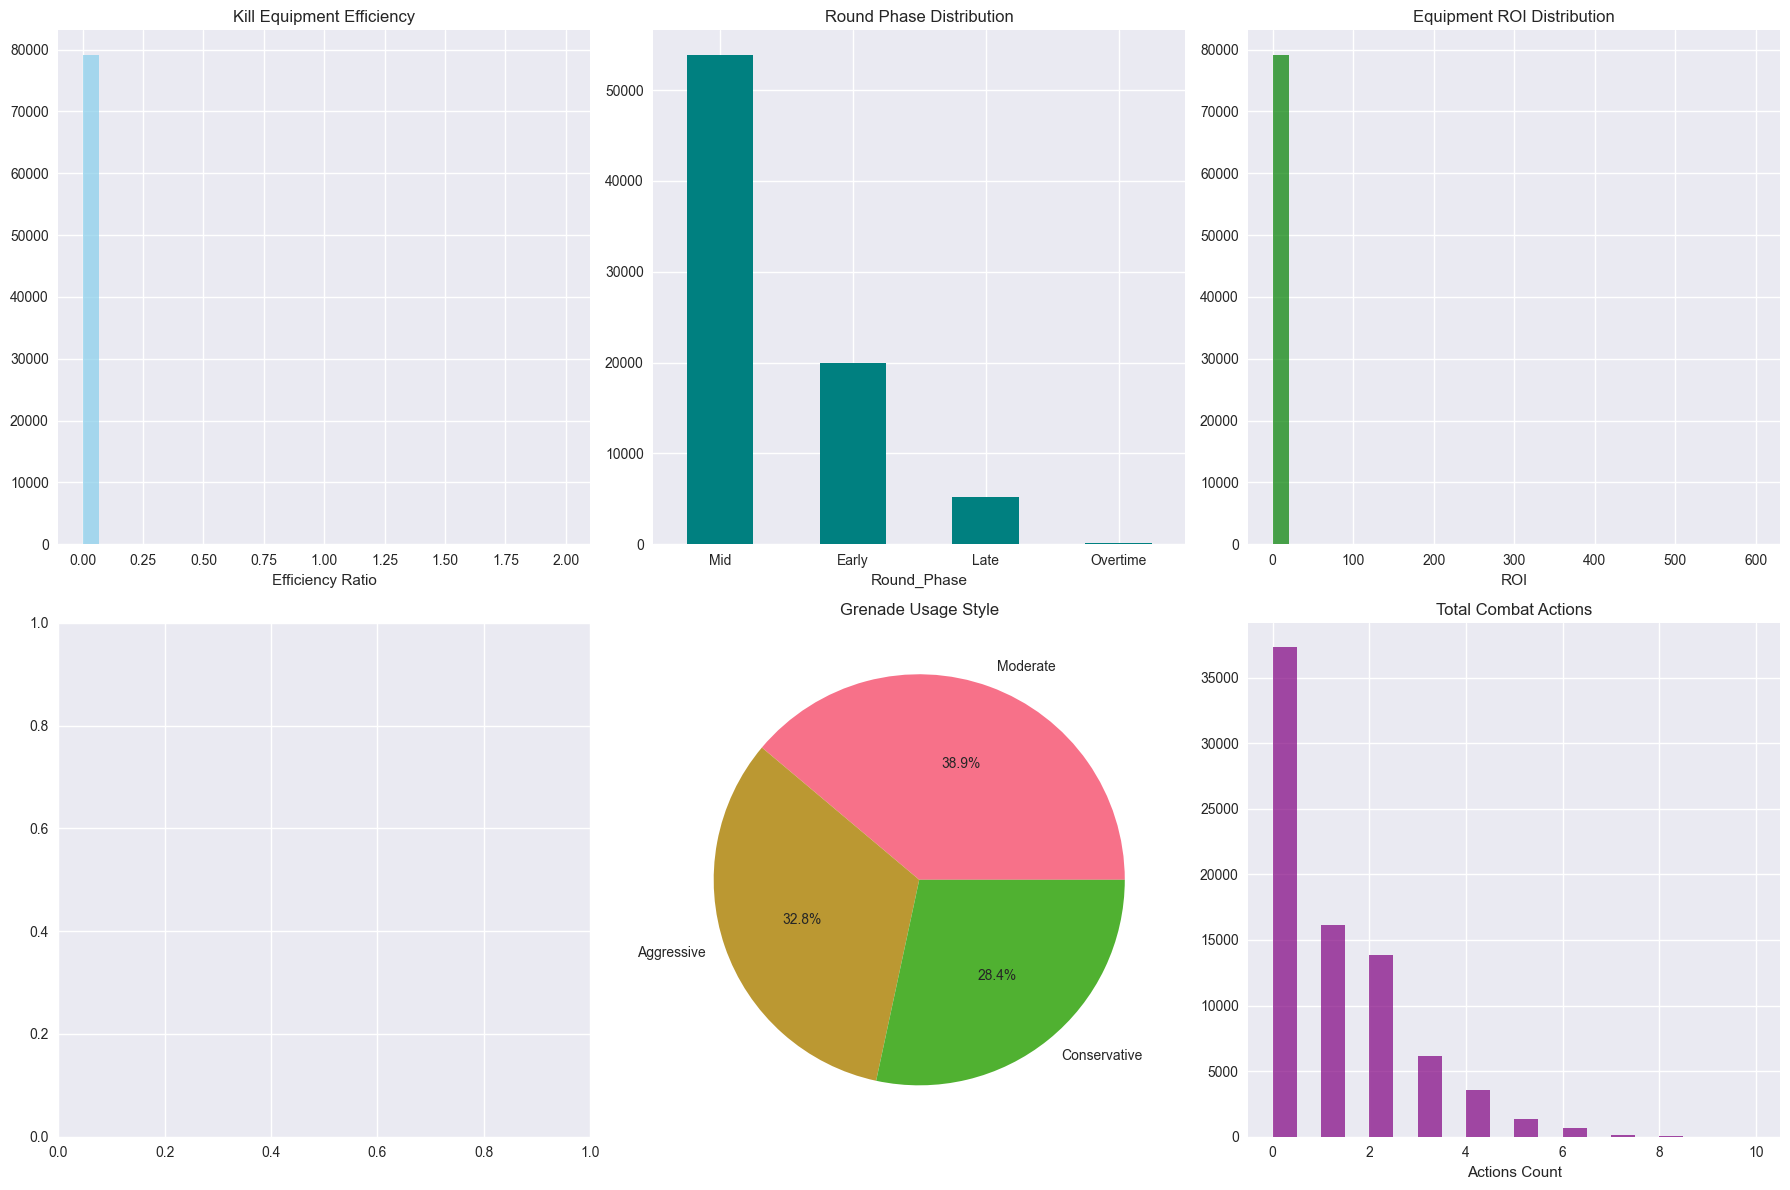

In [39]:
# Visualizar algunas features importantes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Kill Equipment Efficiency
df['Kill_Equipment_Efficiency'].hist(bins=30, ax=axes[0,0], alpha=0.7, color='skyblue')
axes[0,0].set_title('Kill Equipment Efficiency')
axes[0,0].set_xlabel('Efficiency Ratio')

# Round Phase Distribution
df['Round_Phase'].value_counts().plot(kind='bar', ax=axes[0,1], color='teal')
axes[0,1].set_title('Round Phase Distribution')
axes[0,1].tick_params(axis='x', rotation=0)

# Equipment ROI
df['Equipment_ROI'].hist(bins=30, ax=axes[0,2], alpha=0.7, color='green')
axes[0,2].set_title('Equipment ROI Distribution')
axes[0,2].set_xlabel('ROI')

# Grenade Usage Style
df['Grenade_Usage_Style'].value_counts().plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%')
axes[1,1].set_title('Grenade Usage Style')
axes[1,1].set_ylabel('')

# Total Combat Actions
df['Total_Combat_Actions'].hist(bins=20, ax=axes[1,2], alpha=0.7, color='purple')
axes[1,2].set_title('Total Combat Actions')
axes[1,2].set_xlabel('Actions Count')

plt.tight_layout()
plt.show()

## 9. Guardado y Resumen Final

In [40]:
final_shape = df.shape
original_shape = (len(df), 34)  # Dataset limpio actual
new_features = final_shape[1] - original_shape[1]

print("RESUMEN FINAL DEL FEATURE ENGINEERING")
print("=" * 50)
print(f"Dataset original: {original_shape}")
print(f"Dataset final: {final_shape}")
print(f"Nuevas features creadas: {new_features}")
print(f"Incremento: {(new_features/original_shape[1]*100):.1f}%")

# Categorías de features creadas
feature_categories = {
    'Performance': ['Kill_Equipment_Efficiency', 'Total_Combat_Actions', 'Equipment_Investment_Level'],
    'Tactical': ['Weapon_Specialization_Score', 'Grenade_Usage_Style', 'Total_Grenades_Used'],
    'Temporal': ['Round_Phase', 'Match_Progress_Percentage', 'Round_Type'],
    'Economic': ['Equipment_ROI', 'Team_Economic_Strength', 'Team_Coordination_Score'],
    'Interaction': ['Equipment_Kills_Interaction', 'Team_Map_Combination', 'Kills_Assists_Synergy'],
    'Statistical': ['Team_Win_Rate', 'Kills_Last_3_Rounds', 'Cumulative_Kills'],
    'Advanced_Modeling': ['Headshots_Equipment_Interaction', 'Combat_Efficiency', 'Kills_Rolling_3']
}

print(f"\nCATEGORÍAS DE FEATURES:")
for category, examples in feature_categories.items():
    existing = [f for f in examples if f in df.columns]
    print(f"- {category}: {len(existing)} features")
# Análisis de correlación con RoundKills (target principal)
target = 'RoundKills'
numeric_features = df.select_dtypes(include=[np.number]).columns
correlations_with_target = df[numeric_features].corr()[target].abs().sort_values(ascending=False)

print(f"\nTOP 10 FEATURES MÁS CORRELACIONADAS CON {target}:")
for i, (feature, corr) in enumerate(correlations_with_target.head(11).items()):
    if feature != target:  # Excluir autocorrelación
        print(f"{i+1:2d}. {feature:35s}: {corr:.3f}")

# Guardar dataset completo con todas las features
output_path = "../data/04_feature/csgo_data_with_features.csv"
df.to_csv(output_path, index=False)
print(f"\nDataset completo guardado en: {output_path}")
print(f"Tamaño: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 50)
print("FEATURE ENGINEERING COMPLETADO!")
print("Dataset listo para Machine Learning con features optimizadas")
print("=" * 50)

RESUMEN FINAL DEL FEATURE ENGINEERING
Dataset original: (79154, 34)
Dataset final: (79154, 82)
Nuevas features creadas: 48
Incremento: 141.2%

CATEGORÍAS DE FEATURES:
- Performance: 3 features
- Tactical: 3 features
- Temporal: 3 features
- Economic: 2 features
- Interaction: 3 features
- Statistical: 0 features
- Advanced_Modeling: 0 features

TOP 10 FEATURES MÁS CORRELACIONADAS CON RoundKills:
 2. EffectivenessScore                 : 0.977
 3. Total_Combat_Actions               : 0.911
 4. Equipment_Kills_Interaction        : 0.881
 5. Round_Kills_Interaction            : 0.810
 6. RoundHeadshots                     : 0.679
 7. Headshot_Kill_Ratio                : 0.572
 8. Match_Kill_Per_Round               : 0.419
 9. Early_Round_Performance            : 0.412
10. RoundFlankKills                    : 0.391
11. Survived_encoded                   : 0.332

Dataset completo guardado en: ../data/04_feature/csgo_data_with_features.csv
Tamaño: 75.69 MB

FEATURE ENGINEERING COMPLETADO!
Dat

In [41]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

ANÁLISIS DE CORRELACIONES:

Correlaciones altas encontradas (|r| > 0.7):


,Variable_1,Variable_2,Correlation
2,RoundId,Match_Progress_Percentage,1.000000
51,Individual_Equipment_Share,Equipment_Advantage_Ratio,0.999996
48,Match_Progress_Percentage,Rounds_Remaining,-0.999884
3,RoundId,Rounds_Remaining,-0.999884
35,Kill_Equipment_Efficiency,Equipment_ROI,0.999687
12,PrimaryAssaultRifle,Prefers_Rifles,0.997150
14,PrimarySMG,Prefers_SMG,0.993491
13,PrimarySniperRifle,Prefers_AWP,0.993173
20,RoundKills,EffectivenessScore,0.976721
31,MatchKills,Total_Match_Actions,0.972124


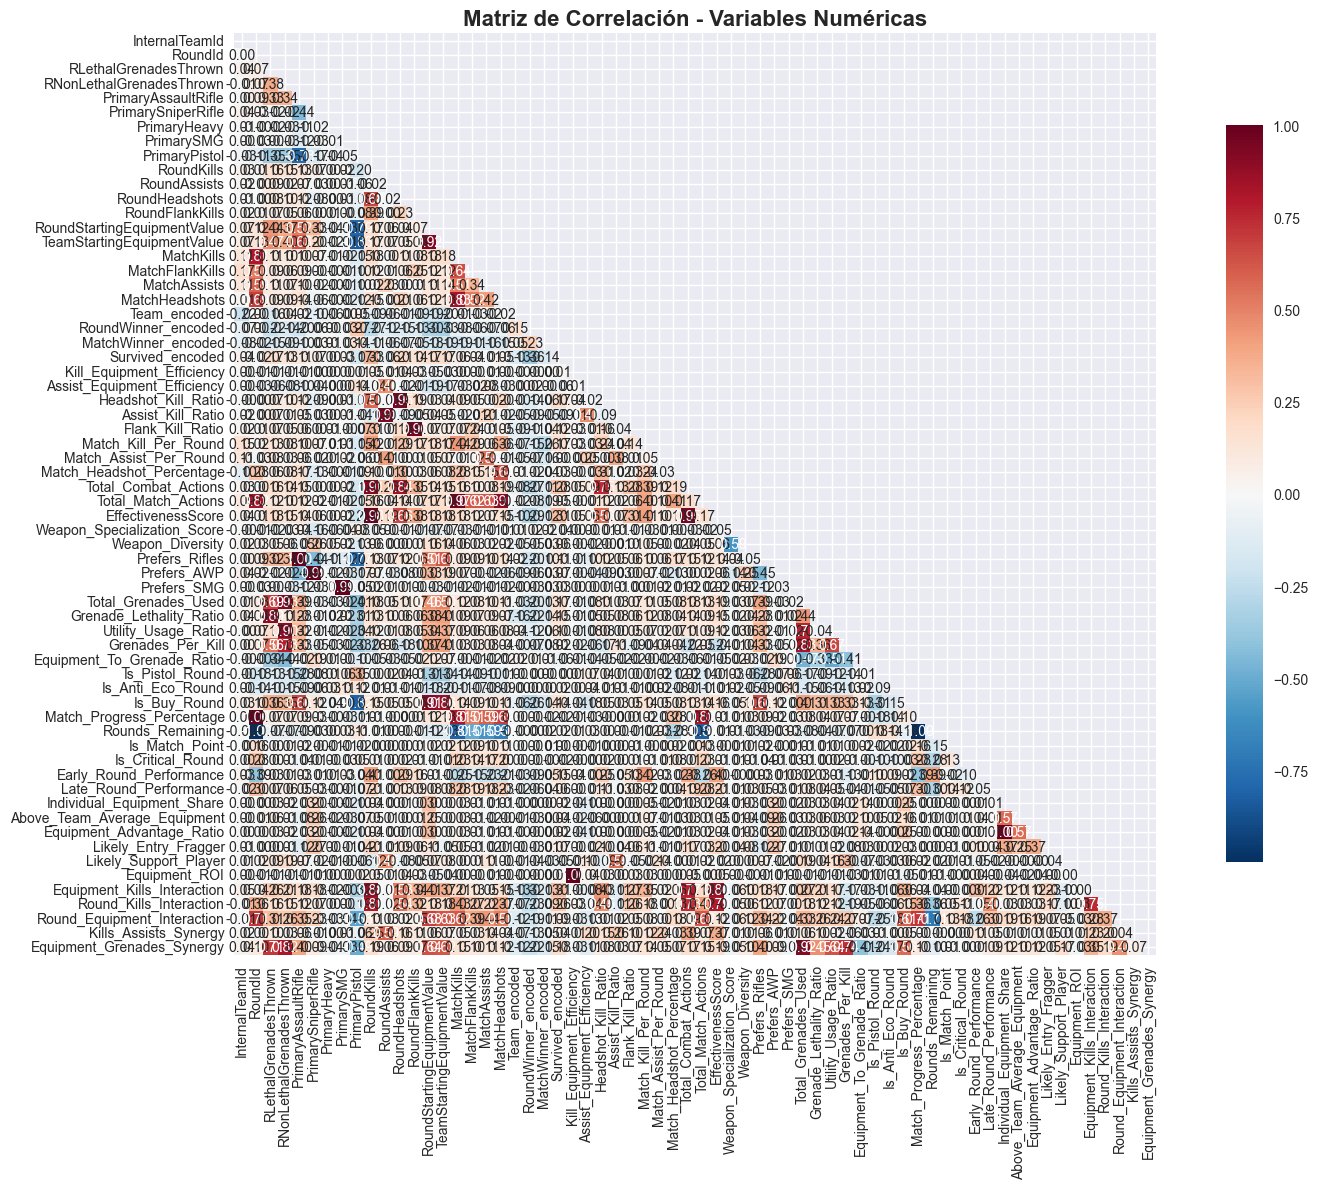

In [42]:
# Matriz de correlación
print("ANÁLISIS DE CORRELACIONES:")
print("="*35)

# Calcular matriz de correlación
correlation_matrix = df[numeric_cols].corr()

# Encontrar correlaciones altas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # Correlación alta
            high_corr_pairs.append({
                'Variable_1': correlation_matrix.columns[i],
                'Variable_2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

print(f"\nCorrelaciones altas encontradas (|r| > 0.7):")
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    display(high_corr_df)
else:
    print("No se encontraron correlaciones muy altas")

# Visualización de la matriz de correlación
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para mostrar solo triángulo inferior
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            mask=mask,
            square=True, 
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()